# Identify tesk-modulated electrodes
See Voytek, 2015 for procedural example; analogous to common single-unit analyses, we will identify task-modulated electrodes.

## Setup

### Set path

In [2]:
PROJECT_PATH = 'C:/Users/micha/projects/oscillation_vs_exponent/'

### Imports

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat


In [4]:
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.utils import trim_spectrum

In [5]:
import sys
sys.path.append(f"{PROJECT_PATH}/code")
from plots import plot_tfr, plot_data_spatial, plot_binary_spatial
from tfr_utils import zscore_tfr, crop_tfr, subtract_baseline, downsample_tfr
from stats import gen_random_order, shuffle_rows, comp_resampling_pval

### Settings

In [6]:
# choose example condition
# FNAME = 'tfr_words_hit_multitaper.json'

In [7]:
# dataset details
FS = 512 # sampling frequency
TMIN = -1.5 # epoch start time
PATIENTS = ['pat02','pat04','pat05','pat08','pat10','pat11','pat15','pat16',
            'pat17','pat19','pat20','pat21','pat22']

In [8]:
# Specparam parameters
N_JOBS = -1 # number of jobs for parallel processing
SPEC_PARAM_SETTINGS = {
    'peak_width_limits' :   [4, 20], # default: (0.5, 12.0)) - reccomends at least frequency resolution * 2
    'min_peak_height'   :   0.1, 
    'max_n_peaks'       :   4, # (default: inf)
    'peak_threshold'    :   2.0, # (default: 2.0)
    'aperiodic_mode'           :   'knee'}

# power analysis (will remove edge artifacts)
WINDOW = 1 # window size for pre/post stimulus power analysis
EDGE = 0.3 # window size for spectral decomposition
N_DOWNSAMPLE = 128 

# band anlysis
# BANDS = Bands({'alpha' : [8, 20]})

### Functions

## Main

#### load results of X_id_modulated_chans

In [10]:
# load results - alpha/beta bandpower modulation (resampling analysis)
results = pd.read_csv(f"{PROJECT_PATH}/data/results/ieeg_modulated_channels.csv")
results.drop(columns=['Unnamed: 0'], inplace=True)

# add significan column
ALPHA = 0.05
results['sig_tm'] = results['pval']<ALPHA

# print results
n_sig_chans = np.sum(results['sig_tm'])
percent_sig = n_sig_chans / len(results) * 100
print(f"Number of significant channels: {n_sig_chans} ({percent_sig:.2f}%)")

results


Number of significant channels: 865 (31.12%)


,patient,material,memory,chan_idx,pval_uncorrected,sign,pval,sig,sig_tm
0,pat02,words,hit,0,0.0360,1.0,0.0360,True,True
1,pat02,words,hit,1,0.0280,1.0,0.0280,True,True
2,pat02,words,hit,2,0.0002,1.0,0.0002,True,True
3,pat02,words,hit,3,0.0014,1.0,0.0014,False,True
4,pat02,words,hit,4,0.0000,1.0,0.0000,True,True
...,...,...,...,...,...,...,...,...,...
2775,pat22,faces,miss,48,0.1656,-1.0,0.1656,False,False
2776,pat22,faces,miss,49,0.9758,-1.0,0.9758,False,False
2777,pat22,faces,miss,50,0.0140,-1.0,0.0140,False,True
2778,pat22,faces,miss,51,0.0368,-1.0,0.0368,False,True


In [11]:
# add channel info to results

# load channel info
chan_info = pd.read_pickle(f'{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.pkl')

# merge
df_merge = pd.merge(results, chan_info, on=['patient','chan_idx'])
df_merge

,patient,material,memory,chan_idx,pval_uncorrected,sign,pval,sig,sig_tm,index,label,pos_y,pos_x,pos_z
0,pat02,words,hit,0,0.0360,1.0,0.0360,True,True,0,A01-A02,-65.431,61.9449,3.55955
1,pat02,words,miss,0,0.4762,1.0,0.4762,True,False,0,A01-A02,-65.431,61.9449,3.55955
2,pat02,faces,hit,0,0.0000,1.0,0.0000,True,True,0,A01-A02,-65.431,61.9449,3.55955
3,pat02,faces,miss,0,0.0092,1.0,0.0092,True,True,0,A01-A02,-65.431,61.9449,3.55955
4,pat02,words,hit,1,0.0280,1.0,0.0280,True,True,1,A02-A03,-70.93895,57.17765,12.1554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2775,pat22,faces,miss,51,0.0368,-1.0,0.0368,False,True,51,MOF_08-MOF_09,48.0,-14.0,23.5
2776,pat22,words,hit,52,0.0560,1.0,0.0560,False,False,52,MOF_09-MOF_10,52.0,-14.0,30.0
2777,pat22,words,miss,52,0.3068,1.0,0.3068,False,False,52,MOF_09-MOF_10,52.0,-14.0,30.0
2778,pat22,faces,hit,52,0.0168,-1.0,0.0168,False,True,52,MOF_09-MOF_10,52.0,-14.0,30.0


In [12]:
# find channels that are significant in both material condition
df_hit = df_merge[df_merge['memory']=='hit']
sig = df_hit.groupby(['patient','chan_idx']).all().reset_index()

# add to df_merge
df_merge['sig'] = np.nan
for ii in range(len(sig)):
    df_merge.loc[(df_merge['patient']==sig.loc[ii, 'patient']) & \
                (df_merge['chan_idx']==sig.loc[ii, 'chan_idx']), 'sig'] \
                    = sig.loc[ii, 'sig_tm']
    
# reduce
df = df_merge[df_merge['sig']==1]

# show
print(f"{int(len(df)/4)} / {int(len(df_merge)/4)} channels ({(len(df)/4) / (len(df_merge)/4) * 100:.2f}%)")
df


145 / 695 channels (20.86%)


,patient,material,memory,chan_idx,pval_uncorrected,sign,pval,sig,sig_tm,index,label,pos_y,pos_x,pos_z
0,pat02,words,hit,0,0.0360,1.0,0.0360,True,True,0,A01-A02,-65.431,61.9449,3.55955
1,pat02,words,miss,0,0.4762,1.0,0.4762,True,False,0,A01-A02,-65.431,61.9449,3.55955
2,pat02,faces,hit,0,0.0000,1.0,0.0000,True,True,0,A01-A02,-65.431,61.9449,3.55955
3,pat02,faces,miss,0,0.0092,1.0,0.0092,True,True,0,A01-A02,-65.431,61.9449,3.55955
4,pat02,words,hit,1,0.0280,1.0,0.0280,True,True,1,A02-A03,-70.93895,57.17765,12.1554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,pat22,faces,miss,36,0.0052,-1.0,0.0052,True,True,36,AC_07-AC_08,23.5,-31.0,42.0
2744,pat22,words,hit,44,0.0210,1.0,0.0210,True,True,44,LOF_08-LOF_09,47.0,-25.0,24.0
2745,pat22,words,miss,44,0.1070,1.0,0.1070,True,False,44,LOF_08-LOF_09,47.0,-25.0,24.0
2746,pat22,faces,hit,44,0.0224,1.0,0.0224,True,True,44,LOF_08-LOF_09,47.0,-25.0,24.0


In [13]:
# Load brain mesh data
fname_mesh = r"C:\Users\micha\datasets\SpectraltiltvsOscillations\Scripts\additional scripts\surface_pial_both.mat"
data_mesh = loadmat(fname_mesh)
pos = data_mesh['mesh']['pos'][0][0]
tri = data_mesh['mesh']['tri'][0][0] - 1 # matlab index begins at 1

# define camera postions for each hemispheres
cpos_right = [(522.8751422878058, -8.533968557192056, 2.1119098264702054),
              (0.21547583547528149, -18.471318770726832, 15.236837161591453),
              (0.023688404036230154, 0.07114592740239216, 0.9971845950115104)]
cpos_left = [(-520.3531805339194, -38.83703309211285, 60.37721009778639),
             (0.21547583547528149, -18.471318770726832, 15.236837161591453),
             (0.08481614834082721, 0.038835387452391915, 0.9956395098940428)]

#### Plot significant channel locations

c:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\pyvista\utilities\helpers.py:475: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


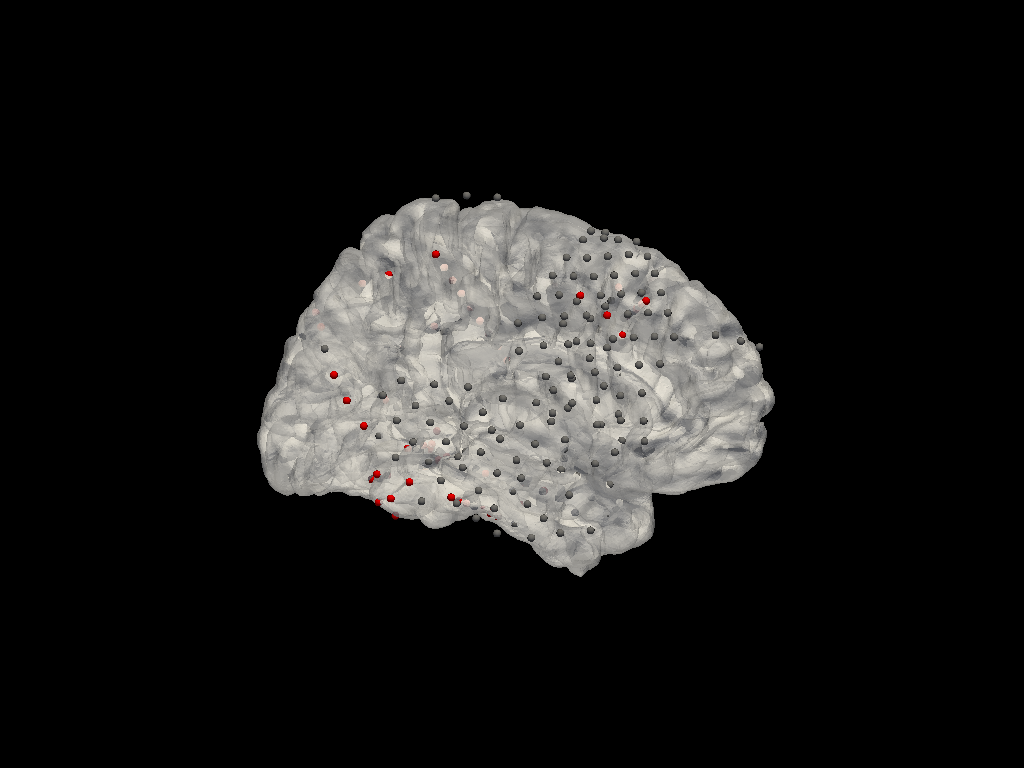

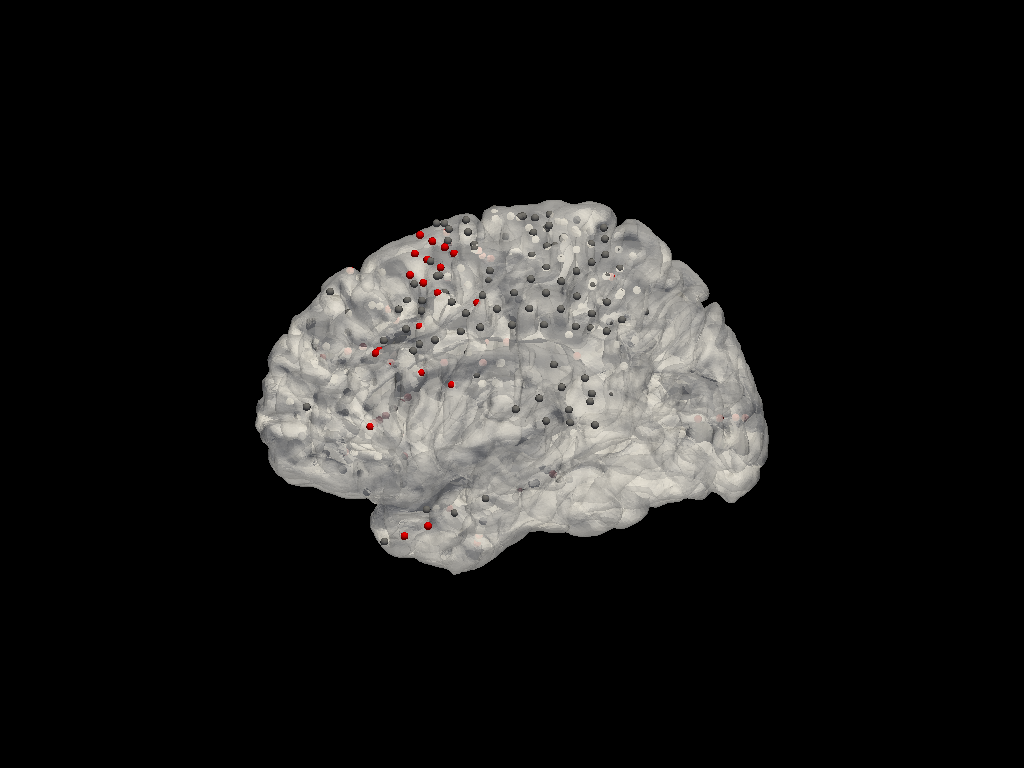

In [15]:
# plot results for an example condition
X_OFFSET = 4

# get electrode positions and p-values (for a condition)
elec_pos = df_merge[['pos_x','pos_y','pos_z']].values.astype(float)
value = df_merge['pval'].values.astype(float)

# plot
for cpos, x_offset in zip([cpos_right, cpos_left], [X_OFFSET, -X_OFFSET]):
    # plot_data_spatial(pos, tri, elec_pos, value, cpos=cpos)
    plot_binary_spatial(pos, tri, elec_pos, df_merge['sig'].values.astype(bool), cpos=cpos,
                        x_offset=x_offset, brain_opacity=0.9, divide_hemispheres=True)
    

#### merge with primary results

In [16]:
# load main statistical results
dir_input = f'{PROJECT_PATH}/data/ieeg_stats/permutation_test'
df_a = pd.read_csv(f'{dir_input}/stats_all.csv')
df_a

,pval_exp,sign_exp,pval_alpha,sign_alpha,chan_idx,patient,material,memory
0,0.88,1.0,0.10,-1.0,0,pat02,face,hit
1,0.04,-1.0,0.00,0.0,1,pat02,face,hit
2,0.24,-1.0,0.00,0.0,2,pat02,face,hit
3,0.86,-1.0,0.28,1.0,3,pat02,face,hit
4,0.02,-1.0,0.00,0.0,4,pat02,face,hit
...,...,...,...,...,...,...,...,...
2775,0.80,1.0,0.16,1.0,48,pat22,word,miss
2776,0.80,1.0,0.00,0.0,49,pat22,word,miss
2777,0.48,-1.0,0.00,0.0,50,pat22,word,miss
2778,0.20,-1.0,0.00,0.0,51,pat22,word,miss


In [22]:
# modify ccolunm names for consistancy between datframes
# df_b = df_merge

# re-load task-modulation results
fname_in = r"C:\Users\micha\projects\oscillation_vs_exponent\data\results\ieeg_modulated_channels.csv"
df_b = pd.read_csv(fname_in, index_col=0)

# modify column names
df_b.drop(columns=['sig_tm'], inplace=True)
df_b.rename(columns={'pval' : 'pval_tm', 'sign' : 'sign_tm', 'sig' : 'sig_tm'}, inplace=True)
for mat in ['words','faces']:
    df_b.loc[df_b['material'] == mat, 'material'] = mat[:-1]

df_b

,patient,material,memory,chan_idx,pval_uncorrected,sign_tm,pval_tm,sig_tm
0,pat02,word,hit,0,0.0360,1.0,0.0360,True
1,pat02,word,hit,1,0.0280,1.0,0.0280,True
2,pat02,word,hit,2,0.0002,1.0,0.0002,True
3,pat02,word,hit,3,0.0014,1.0,0.0014,False
4,pat02,word,hit,4,0.0000,1.0,0.0000,True
...,...,...,...,...,...,...,...,...
2775,pat22,face,miss,48,0.1656,-1.0,0.1656,False
2776,pat22,face,miss,49,0.9758,-1.0,0.9758,False
2777,pat22,face,miss,50,0.0140,-1.0,0.0140,False
2778,pat22,face,miss,51,0.0368,-1.0,0.0368,False


In [23]:
# join
df_merge = pd.merge(df_a, df_b, on=['patient','chan_idx','material','memory'])
df_merge


,pval_exp,sign_exp,pval_alpha,sign_alpha,chan_idx,patient,material,memory,pval_uncorrected,sign_tm,pval_tm,sig_tm
0,0.88,1.0,0.10,-1.0,0,pat02,face,hit,0.0000,1.0,0.0000,True
1,0.04,-1.0,0.00,0.0,1,pat02,face,hit,0.0000,1.0,0.0000,True
2,0.24,-1.0,0.00,0.0,2,pat02,face,hit,0.0000,1.0,0.0000,True
3,0.86,-1.0,0.28,1.0,3,pat02,face,hit,0.0830,1.0,0.0830,False
4,0.02,-1.0,0.00,0.0,4,pat02,face,hit,0.0014,1.0,0.0014,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2775,0.80,1.0,0.16,1.0,48,pat22,word,miss,0.7494,-1.0,0.7494,False
2776,0.80,1.0,0.00,0.0,49,pat22,word,miss,0.3022,1.0,0.3022,False
2777,0.48,-1.0,0.00,0.0,50,pat22,word,miss,0.1346,1.0,0.1346,False
2778,0.20,-1.0,0.00,0.0,51,pat22,word,miss,0.0776,1.0,0.0776,False


#### count overlap between task-modulated channels and main statistical results

In [24]:
# add significance
df = df_merge.copy()

# determine significance
# df['sig_tm'] = np.where(df['pval_tm'] < ALPHA, 1, 0)
df['sig_exp'] = np.where(df['pval_exp'] < ALPHA, 1, 0)
df['sig_alpha'] = np.where(df['pval_alpha'] < ALPHA, 1, 0)

# print percentage of task-modulated channels that are also significant for each param
n_rows = df.shape[0]
df.groupby(['material','memory']).sum() / n_rows * 4 * 100

pval_exp   sign_exp  pval_alpha  sign_alpha     chan_idx  \
material memory                                                              
face     hit     38.017266 -18.273381   13.404317    1.582734  3210.647482   
         miss    38.702158 -18.561151   11.623022   -3.453237  3210.647482   
word     hit     37.312230 -31.079137   14.448921   -0.575540  3210.647482   
         miss    42.469065 -28.057554   15.410072    1.151079  3210.647482   

                 pval_uncorrected    sign_tm    pval_tm     sig_tm    sig_exp  \
material memory                                                                 
face     hit            28.606619  13.669065  28.254993  20.863309  23.309353   
         miss           27.776547   7.913669  27.764201  20.863309  21.438849   
word     hit            26.750446  17.122302  26.740317  20.863309  22.446043   
         miss           38.391568  25.179856  38.281324  20.863309  16.546763   

                 sig_alpha  
material memory             
face     hit     38.129496  
         miss    42.877698  
word     hit     34.388489  
         miss    40.143885

In [33]:
# reduce df to task-modulated channels only 
df_sig = df.loc[df['sig_tm']==1]
n_sig = len(df_sig)  / 4

# print percentage of task-modulated channels that are also significant for each param
df_overlap = df_sig.groupby(['material','memory']).sum() / n_sig  * 100
df_overlap[['sig_exp','sig_alpha']]

sig_exp  sig_alpha
material memory                      
face     hit     43.448276  47.586207
         miss    40.000000  51.034483
word     hit     31.034483  36.551724
         miss    28.275862  36.551724